In [30]:
!mkdir /content/output

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [3]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.3.0


In [31]:
base_image_path = Path("/content/familia.jpg")
style_reference_image_path = Path("/content/milo-lockett.jpg")
result_prefix = Path("/content/output")
iterations = 100

In [32]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [33]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [34]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [35]:
img_content = load_img(base_image_path, target_size=(img_nrows, img_ncols))
img_style = load_img(style_reference_image_path, target_size=(img_nrows, img_ncols))

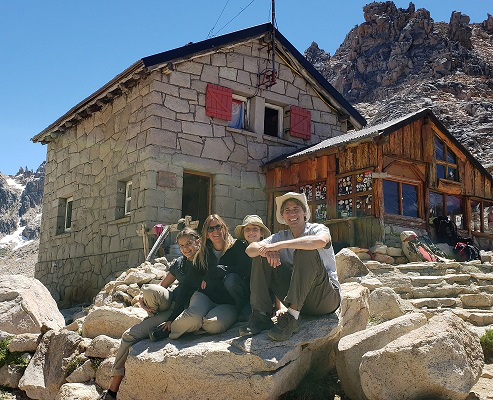

In [36]:
img_content

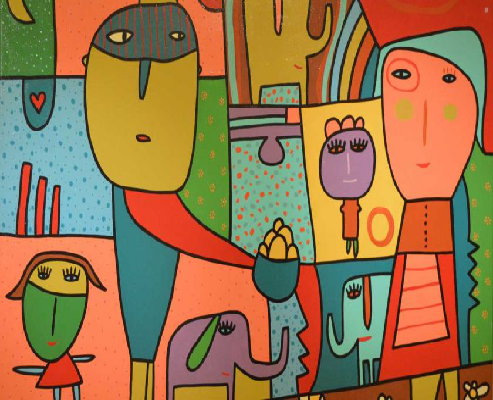

In [37]:
img_style

In [38]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [39]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [40]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [41]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [42]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [43]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [44]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [45]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [46]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [47]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [48]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [49]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [50]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [51]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())

    #fname = result_prefix / ('output_at_iteration_%d.png' % i)
    fname = result_prefix / ('output_S%02d_C%02d_iter_%02d.png' % (style_weight,content_weight, i))
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 67872800000.0
Image saved as /content/output/output_S10_C01_iter_00.png
Iteration 0 completed in 5s
Start of iteration 1
Current loss value: 31347765000.0
Image saved as /content/output/output_S10_C01_iter_01.png
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 21182935000.0
Image saved as /content/output/output_S10_C01_iter_02.png
Iteration 2 completed in 5s
Start of iteration 3
Current loss value: 16736534000.0
Image saved as /content/output/output_S10_C01_iter_03.png
Iteration 3 completed in 5s
Start of iteration 4
Current loss value: 14135746000.0
Image saved as /content/output/output_S10_C01_iter_04.png
Iteration 4 completed in 5s
Start of iteration 5
Current loss value: 12454254000.0
Image saved as /content/output/output_S10_C01_iter_05.png
Iteration 5 completed in 5s
Start of iteration 6
Current loss value: 11147124000.0
Image saved as /content/output/output_S10_C01_iter_06.png
Iteration 6 completed in 5s
Start of iter